<a href="https://colab.research.google.com/github/mahesh-keswani/ML-DL-Basics/blob/main/PreTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # Resources:
# https://www.youtube.com/watch?v=_GRvjpJVr5A&list=PLyqSpQzTE6M9gCgajvQbc68Hk_JKGBAYT&index=71
# https://machinelearningmastery.com/greedy-layer-wise-pretraining-tutorial/

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [3]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

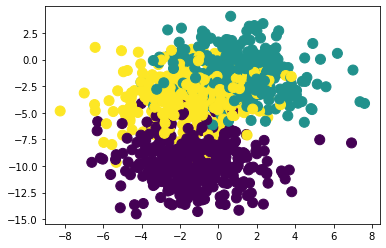

In [4]:
plt.scatter( X[:, 0], X[:, 1], c=y, s=100 );

In [5]:
# We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line), 
# causing many ambiguous points.
# This is desirable as it means that the problem is non-trivial and will allow a neural network model 
# to find many different “good enough” candidate solutions.

<h1>Supervised Greedy Layer-Wise Pretraining</h1>

In [6]:
n_train = 500
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

In [7]:
# define and fit the base model
def get_base_model(trainX, trainy):
	# define model
	model = Sequential()
	model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(3, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy, epochs=100, verbose=0)
	return model

In [8]:
# We can call this function to prepare the base model to which we can later add layers one at a time.

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

In [10]:
# get the base model
model = get_base_model(X_train, y_train)

In [11]:
# evaluate a fit model
def evaluate_model(model, trainX, testX, trainy, testy):
    _, train_acc = model.evaluate(trainX, trainy, verbose=0)
    _, test_acc = model.evaluate(testX, testy, verbose=0)

    return train_acc, test_acc

In [12]:
train_acc, test_acc = evaluate_model(model, X_train, X_test, y_train, y_test)

In [13]:
print("Layers: {}, Train Accuracy: {}, Test Accuracy: {}".format( len(model.layers), train_acc, test_acc ) )

Layers: 2, Train Accuracy: 0.828000009059906, Test Accuracy: 0.8339999914169312


In [14]:
# This will store number of layers as key and value will be (train_acc, test_acc)
scores = dict()
scores[ len(model.layers) ] = (train_acc, test_acc)

In [15]:
# add one new layer and re-train only the new layer
def add_layer(model, trainX, trainy):
    # remember the current output layer
    output_layer = model.layers[-1]

    # remove the output layer
    model.pop()

    # mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable = False

    # add a new hidden layer
    model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))

    # re-add the output layer
    model.add(output_layer)
    
    # fit model
    model.fit(trainX, trainy, epochs=100, verbose=0)

In [16]:
# add layers and evaluate the updated model
n_layers = 10
for i in range(n_layers):
    # add layer
    add_layer(model, X_train, y_train)

    # evaluate model
    train_acc, test_acc = evaluate_model(model, X_train, X_test, y_train, y_test)
    print('> layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
    
    # store scores for plotting
    scores[len(model.layers)] = (train_acc, test_acc)

> layers=3, train=0.822, test=0.836
> layers=4, train=0.836, test=0.832
> layers=5, train=0.822, test=0.830
> layers=6, train=0.826, test=0.836
> layers=7, train=0.834, test=0.830
> layers=8, train=0.840, test=0.824
> layers=9, train=0.834, test=0.826
> layers=10, train=0.844, test=0.826
> layers=11, train=0.838, test=0.828
> layers=12, train=0.840, test=0.824


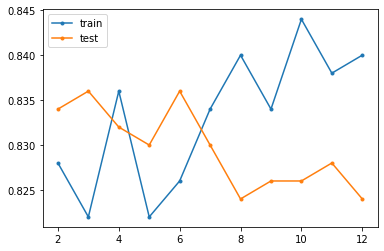

In [17]:
# plot number of added layers vs accuracy
plt.plot(list(scores.keys()), [scores[k][0] for k in scores.keys()], label='train', marker='.')
plt.plot(list(scores.keys()), [scores[k][1] for k in scores.keys()], label='test', marker='.')
plt.legend();

In [18]:
# In this case, the plot suggests a slight overfitting of the training dataset, but perhaps better test 
# set performance after 5 added layers.

In [19]:
# An interesting extension to this example would be to allow all weights in the model to be fine tuned with a small learning rate 
# for a large number of training epochs to see if this can further reduce generalization error.

<h1>Unsupervised Greedy Layer-Wise Pretraining</h1>

In [20]:
# Specifically, we will develop an autoencoder model that will be trained to reconstruct input data. 
# In order to use this unsupervised model for classification, 
# we will remove the output layer, add and fit a new output layer for classification.

In [21]:
def base_autoencoder(trainX, testX):
	# define model
    model = Sequential()
    model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    # 2 because the dimenions of the input_data is 2
    model.add(Dense(2, activation='linear'))

    # compile model
    model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))

    # fit model
    model.fit(trainX, trainX, epochs=100, verbose=0)

    # evaluate reconstruction loss
    train_mse = model.evaluate(trainX, trainX, verbose=0)
    test_mse = model.evaluate(testX, testX, verbose=0)
    
    print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))
    return model

In [28]:
# get the base autoencoder
model = base_autoencoder(X_train, X_test)

> reconstruction error train=0.000, test=0.000


In [29]:
# evaluate the autoencoder as a classifier
def evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy):
	# remember the current output layer
	output_layer = model.layers[-1]

	# remove the output layer
	model.pop()
 
	# mark all remaining layers as non-trainable
	for layer in model.layers:
		layer.trainable = False

	# add new output layer
	model.add(Dense(3, activation='softmax'))
 
	# compile model
	model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])
 
	# fit model
	model.fit(trainX, trainy, epochs=100, verbose=0)
 
	# evaluate model
	_, train_acc = model.evaluate(trainX, trainy, verbose=0)
	_, test_acc = model.evaluate(testX, testy, verbose=0)
 
	# put the model back together
	model.pop() # pop out the classification layer
    
	model.add(output_layer) # again adding back the reconstruction layer
 
	model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
	return train_acc, test_acc
 

In [30]:
# evaluate the base model
scores = dict()
train_acc, test_acc = evaluate_autoencoder_as_classifier(model, X_train, y_train, X_test, y_test)

print('> classifier accuracy layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))

> classifier accuracy layers=2, train=0.820, test=0.834


In [31]:
scores[len(model.layers)] = (train_acc, test_acc)

In [32]:
# add one new layer and re-train only the new layer
def add_layer_to_autoencoder(model, trainX, testX):
    # remember the current output layer
    output_layer = model.layers[-1]

    # remove the output layer
    model.pop()

    # mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable = False

    # add a new hidden layer
    model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))

    # re-add the output layer
    model.add(output_layer)

    # fit model
    model.fit(trainX, trainX, epochs=100, verbose=0)

    # evaluate reconstruction loss
    train_mse = model.evaluate(trainX, trainX, verbose=0)
    test_mse = model.evaluate(testX, testX, verbose=0)

    print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))

In [33]:
# add layers and evaluate the updated model
n_layers = 5
for _ in range(n_layers):
	# add layer
	add_layer_to_autoencoder(model, X_train, X_test)
 
	# evaluate model
	train_acc, test_acc = evaluate_autoencoder_as_classifier(model, X_train, y_train, X_test, y_test)
 
	print('> classifier accuracy layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
 
	# store scores for plotting
	scores[len(model.layers)] = (train_acc, test_acc)

> reconstruction error train=0.013, test=0.017
> classifier accuracy layers=3, train=0.824, test=0.838
> reconstruction error train=0.035, test=0.048
> classifier accuracy layers=4, train=0.822, test=0.830
> reconstruction error train=10.409, test=10.675
> classifier accuracy layers=5, train=0.342, test=0.326
> reconstruction error train=10.409, test=10.665
> classifier accuracy layers=6, train=0.342, test=0.326
> reconstruction error train=10.408, test=10.669
> classifier accuracy layers=7, train=0.342, test=0.326


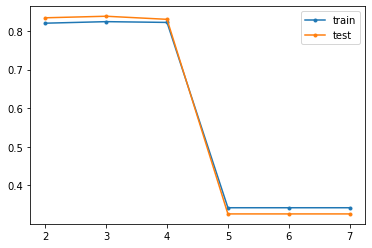

In [34]:
keys = list(scores.keys())
plt.plot(keys, [scores[k][0] for k in keys], label='train', marker='.')
plt.plot(keys, [scores[k][1] for k in keys], label='test', marker='.')
plt.legend()

In [35]:
# In this case, we can see that reconstruction error starts low, in fact near-perfect, then slowly increases during training. 
# Accuracy on the training dataset seems to decrease as layers are added to the encoder, although accuracy 
# test seems to improve as layers are added, at least until the model has 4 layers, after which performance appears to crash

In [ ]:
# In this case, the plot suggests there may be some minor benefits 
# in the unsupervised greedy layer-wise pretraining, but perhaps beyond 4 layers the model becomes unstable